# Compute  PCA : Method 1 : 2D projection

- use PCA scikit learn from scikit learn

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/12/27
- update : 2022/12/28

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from mpl_toolkits.mplot3d import axes3d  

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

from astroML.utils.decorators import pickle_results


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [3]:
from sklearn.decomposition import NMF, FastICA, PCA

In [4]:
from astropy.io import fits

In [5]:
filename = 'datatools/pca_SL_data.fits'
hdu = fits.open(filename)
data_in=hdu[0].data
hdr_in = hdu[0].header

In [6]:
hdr_in

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6362                                                  
NAXIS2  =                  553                                                  
DATAWLS = 'data[0,1:]'                                                          
DATALLAV= 'data[1,1:]'                                                          
DATALLST= 'data[2,1:]'                                                          
DATAFL  = 'data[3:,1:]'                                                         
DATANUM = 'data[3:,0]'                                                          
COMMENT Spectra of StarLight                                                    

In [7]:
data_in

array([[0.00000000e+00, 9.10000000e+01, 9.40000000e+01, ...,
        9.95000000e+03, 9.97000000e+03, 9.99000000e+03],
       [0.00000000e+00, 4.97839069e-07, 5.52382959e-07, ...,
        7.06085364e-05, 7.06330908e-05, 7.05906948e-05],
       [0.00000000e+00, 1.19574179e-06, 1.27758431e-06, ...,
        4.46025945e-05, 4.46908296e-05, 4.46647757e-05],
       ...,
       [7.36000000e+02, 2.14675694e-06, 2.50389986e-06, ...,
        2.12861759e-05, 2.12363909e-05, 2.11664152e-05],
       [7.37000000e+02, 8.31448778e-07, 9.57832321e-07, ...,
        7.00733914e-05, 6.99426115e-05, 7.00519814e-05],
       [7.38000000e+02, 7.21010321e-08, 8.01113405e-08, ...,
        1.50517900e-04, 1.50795383e-04, 1.50744720e-04]])

In [8]:
NSED = data_in.shape[0]-3
NWL = data_in.shape[1]-1

In [9]:
wavelengths = data_in[0,1:] 
flambdas_average = data_in[1,1:] 
flambdas_std = data_in[2,1:] 
spec = data_in[3:,1:] 
all_numbers = data_in[3:,0] 

In [10]:
#flux = dfluxnorm*flambdas_std +  flambdas_average

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_66677/1659706449.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Flux average')

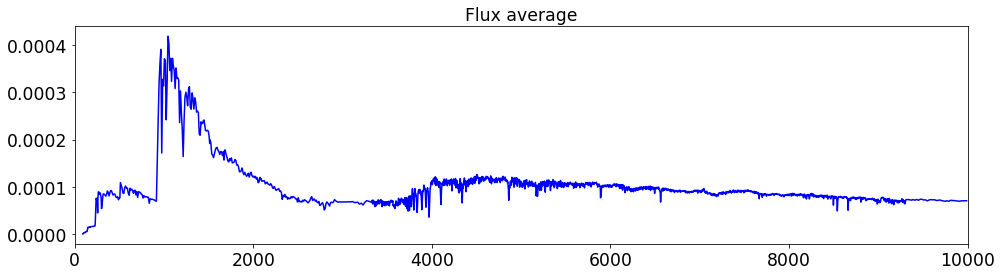

In [11]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths,flambdas_average,'b-')
plt.xlim(0.,10000.)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title("Flux average")

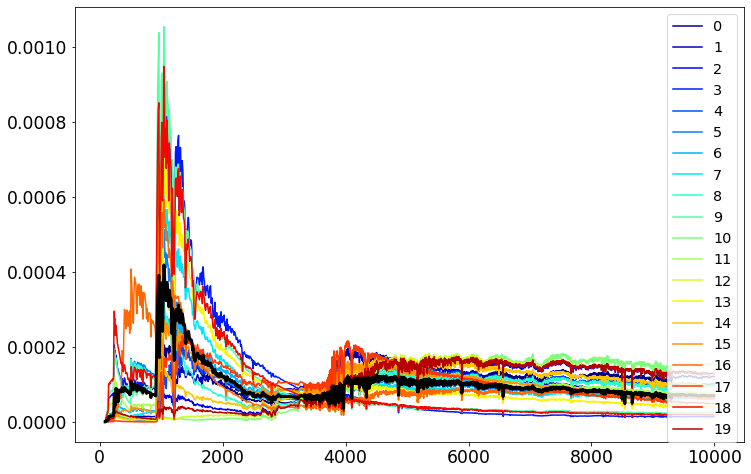

In [12]:
# wavelength bin colors
NTOPLOT=20
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)


fig = plt.figure(figsize=(12, 8))

for idx in np.arange(20):
    plt.plot(wavelengths,spec[idx,:],color=all_colors[idx],label=str(idx))

plt.legend()
spec_mean = spec.mean(0)
plt.plot(wavelengths,spec_mean,"k-",lw=3)
#plt.ylim(0,50.)

In [13]:
#https://www.astroml.org/astroML-notebooks/chapter7/astroml_chapter7_Dimensionality_Reduction.html
#https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
"""
X_recons: ndarray, shape = (n_samples, n_features)       data with masked regions reconstructed
mu: ndarray, shape = (n_features,)                       mean of data
evecs: ndarray, shape = (min(n_samples, n_features), n_features) eigenvectors of the reconstructed data
evals: ndarray, size = min(n_samples, n_features)        eigenvalues of the reconstructed data
norms: ndarray, size = n_samples                         normalization of each input
coeffs: ndarray, size = (n_samples, n_ev)                coefficients used to reconstruct X
"""

'\nX_recons: ndarray, shape = (n_samples, n_features)       data with masked regions reconstructed\nmu: ndarray, shape = (n_features,)                       mean of data\nevecs: ndarray, shape = (min(n_samples, n_features), n_features) eigenvectors of the reconstructed data\nevals: ndarray, size = min(n_samples, n_features)        eigenvalues of the reconstructed data\nnorms: ndarray, size = n_samples                         normalization of each input\ncoeffs: ndarray, size = (n_samples, n_ev)                coefficients used to reconstruct X\n'

In [14]:
Ncomp=10
pca = PCA(n_components=Ncomp)
pca.fit(spec)
#coefficients of each spectra projected in Eigenvector base:
pca_coeffs = pca.transform(spec)
#eigen vectors (Ncomp vectors) 
pca_eignevector = pca.components_

#explained_variance_ is eigen value
#evals = pca.explained_variance_ratio_
evals = pca.explained_variance_  # eigen-values
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]

In [15]:
evals

array([1.50747493e-05, 1.61699178e-06, 6.41351285e-07, 2.06146996e-07,
       7.67167128e-08, 3.30620596e-08, 1.59623539e-08, 6.45871958e-09,
       4.69099663e-09, 3.24458766e-09])

In [16]:
evals_cs

array([0.85267434, 0.94413639, 0.9804132 , 0.99207351, 0.99641284,
       0.99828293, 0.99918581, 0.99955114, 0.99981648, 1.        ])

In [17]:
pca.singular_values_.shape

(10,)

In [18]:
pca.singular_values_

array([0.09097273, 0.02979477, 0.01876438, 0.01063836, 0.0064898 ,
       0.00426041, 0.00296029, 0.00188304, 0.00160479, 0.00133465])

In [19]:
# Eigen vectors
evecs = pca.components_

In [20]:
import copy
X = copy.deepcopy(spec)
n_samples = X.shape[0]
X -= np.mean(X, axis=0)
cov_matrix = np.dot(X.T, X) / n_samples
for idx,eigenvector in enumerate(pca.components_):
    print(f"eigen value {idx} : ",np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

eigen value 0 :  1.5047340681032525e-05
eigen value 1 :  1.6140517991809827e-06
eigen value 2 :  6.401851922302356e-07
eigen value 3 :  2.0577218285708617e-07
eigen value 4 :  7.657722784310634e-08
eigen value 5 :  3.300194676016747e-08
eigen value 6 :  1.5933331468502894e-08
eigen value 7 :  6.446976452454413e-09
eigen value 8 :  4.682467544806023e-09
eigen value 9 :  3.2386884142199316e-09


In [21]:
evecs.shape

(10, 6361)

In [22]:
#------------------------------------------------------------
# Find the coefficients of a particular spectrum
all_coeff = []
for idx in range(NSED):
    the_spec = spec[idx,:]
    coeff = np.dot(evecs, the_spec - spec_mean)
    all_coeff.append(coeff)


In [23]:
all_coeff=np.vstack(all_coeff)

In [24]:
all_coeff.shape

(550, 10)

In [25]:
pca_coeffs.shape

(550, 10)

In [26]:
# computed coeff by me
all_coeff[0,:]

array([-2.25712044e-03,  6.57533259e-04, -9.50868170e-04, -4.83666987e-04,
        3.52339363e-04,  1.62112917e-05,  1.41391652e-04, -8.84901065e-05,
       -1.80317333e-05,  1.37565070e-05])

In [27]:
# computed coeff by PCA algorithm
pca_coeffs[0,:]

array([-2.25712044e-03,  6.57533259e-04, -9.50868170e-04, -4.83666987e-04,
        3.52339363e-04,  1.62112917e-05,  1.41391652e-04, -8.84901065e-05,
       -1.80317333e-05,  1.37565070e-05])

Text(0, 0.5, 'coeff 1')

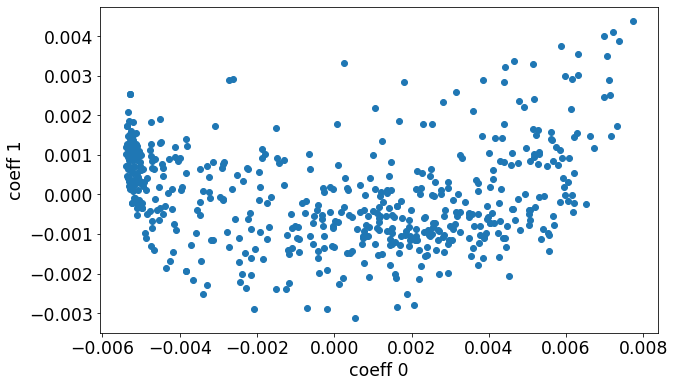

In [28]:
plt.scatter(all_coeff[:,0],all_coeff[:,1])
plt.xlabel("coeff 0")
plt.ylabel("coeff 1")

Text(0, 0.5, 'coeff 2')

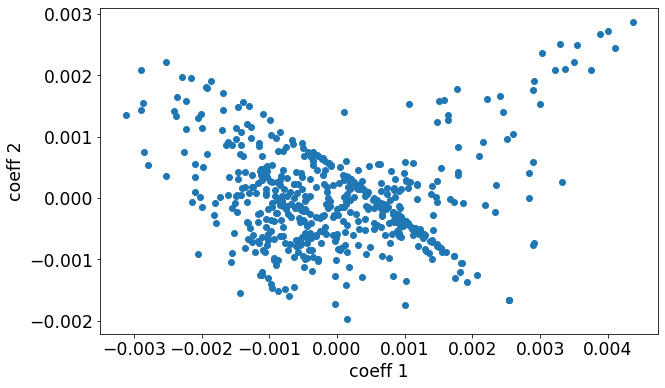

In [29]:
plt.scatter(all_coeff[:,1],all_coeff[:,2])
plt.xlabel("coeff 1")
plt.ylabel("coeff 2")

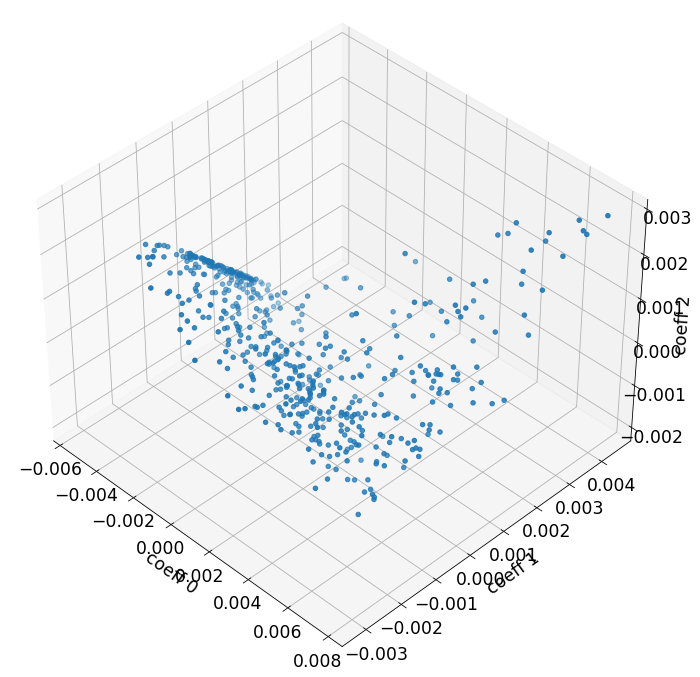

In [30]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(all_coeff[:,0],all_coeff[:,1],all_coeff[:,2], marker="o")
ax.set_xlabel('coeff 0')
ax.set_ylabel('coeff 1')
ax.set_zlabel('coeff 2')

# rotate the axes and update
#for angle in range(0, 360):
ax.view_init(40, -45)
#plt.draw()
#plt.pause(.001)
plt.show()
    


# Save coefficients in a fits file

In [31]:
filename_out = "pcamethod1_SL_eigenvectorandcoeff.fits"
hdr = fits.Header()
hdr["COMMENT"] = "PCA method 1 spectra coefficients"
hdr2 = fits.Header()
hdr2["COMMENT"] = "PCA method 1 Eigen Vectors"

In [32]:
primary_hdu = fits.PrimaryHDU(data_in,hdr_in)
image_hdu = fits.ImageHDU(pca_coeffs,hdr)
image_hdu2 = fits.ImageHDU(pca.components_,hdr2)

In [33]:
hdul = fits.HDUList([primary_hdu, image_hdu, image_hdu2])

In [34]:
hdul.writeto(filename_out,overwrite=True)